# Predictive Analysis on Clinical Trial Outcomes

#### Investigator
- [Nicholas S. McBride, PhD](https://www.linkedin.com/in/nsmcbride/)

## Section 4: Modeling

##### [ClinicalTrials.gov](https://clinicaltrials.gov/) Reference Links

- [API documentation](https://clinicaltrials.gov/data-api/api)
- [Data structure](https://clinicaltrials.gov/data-api/about-api/study-data-structure)
- [ESSIE query syntax](https://clinicaltrials.gov/find-studies/constructing-complex-search-queries)

In [1]:
# Imports
import numpy as np
import pandas as pd
import bz2
import pickle
from time import time
from os import cpu_count

# Preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.over_sampling import SMOTE

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Google Colab environment dependent imports

# Determine if runtime is a Google Colab environment
colab = 'google.colab' in str(get_ipython())

# Workspace settings
if colab:
    from sklearn.metrics import mean_squared_error
    def root_mean_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

    project_path = data_path = './'

else:
    from sklearn.metrics import root_mean_squared_error
    project_path = '../'
    data_path = project_path + 'data/'

# Visualization settings
%config InlineBackend.figure_formats = ['retina'] # High res PNGs

In [3]:
# Read DataFrame from pickle
start_time = time()
studies = pd.read_pickle(data_path + 'studies_encoded.pkl.bz2')
print(f'Data loaded in {round(time() - start_time, 1)}s')

Data loaded in 2.0s


### Simplest Model
The initial model to be created will be the simplest model: binary classification of Completed vs. Incomplete (Terminated, Suspended, Withdrawn, or Unknown) recruitment status studies only. Other `OverallStatus` types will be dropped.

In [4]:
studies.dtypes.value_counts()

int32       302
bool        240
float32      12
category      1
Name: count, dtype: int64

There are still NaN values in the time duration fields. These will be filled with zeros.

In [5]:
studies.loc[:, studies.isna().any()].isna().sum() / studies.shape[0]

PrimaryCompletionDate    0.054023
CompletionDate           0.040487
EnrollmentCount          0.015746
MinimumAge               0.068702
MaximumAge               0.459911
DispFirstSubmitDate      0.977165
DispFirstSubmitQCDate    0.978786
TargetDuration           0.981477
dtype: float64

In [6]:
studies.loc[:, studies.isna().any()] = studies.loc[:, studies.isna().any()].fillna(0)
studies.isna().sum().sum()

0

#### Train/Test Split

In [7]:
recruitment = ['COMPLETED', 'SUSPENDED', 'TERMINATED' , 'WITHDRAWN', 'UNKNOWN']
expanded_access = ['AVAILABLE', 'NO_LONGER_AVAILABLE', 'TEMPORARILY_NOT_AVAILABLE', 'APPROVED_FOR_MARKETING']

# Define a conversion dictionary for the simplified model
recruitment_simplified = dict(zip(recruitment, [recruitment[0].title()] + ['Not Completed'] * (len(recruitment) - 1)))
recruitment_simplified

{'COMPLETED': 'Completed',
 'SUSPENDED': 'Not Completed',
 'TERMINATED': 'Not Completed',
 'WITHDRAWN': 'Not Completed',
 'UNKNOWN': 'Not Completed'}

In [8]:
# Subset the data and convert the target variable
X = studies.loc[studies['OverallStatus'].isin(recruitment), studies.columns != 'OverallStatus']
print(f'X.shape: {X.shape}')

y = studies.loc[studies['OverallStatus'].isin(recruitment), 'OverallStatus'].map(recruitment_simplified)
print(f'y.shape: {y.shape}')

X.shape: (382196, 554)
y.shape: (382196,)


Take note of the column indices for different variable types.

In [9]:
bool_cols = X.select_dtypes(bool).columns
bool_icols = [X.columns.get_loc(col) for col in bool_cols]

num_cols = X.select_dtypes('number').columns
num_ilocs = [X.columns.get_loc(col) for col in num_cols]

print(f'Boolean columns:\t{len(bool_cols)}')
print(f'Numerical columns:\t{len(num_cols)}')
print(f'Total columns:\t\t{X.shape[1]}')

Boolean columns:	240
Numerical columns:	314
Total columns:		554


y will be encoded as a boolean with 'Completed' = True and 'Not Completed' = False.

In [10]:
y.value_counts()

OverallStatus
Completed        270479
Not Completed    111717
Name: count, dtype: int64

In [11]:
y = y.map({'Completed': True,
           'Not Completed': False})
y.value_counts()

OverallStatus
True     270479
False    111717
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=38)

#### Scale Data
Build a ColumnTransformer to allow scaling of only numerical data. Ultimately, this did not give improved model performance while taking longer for the models to converge, so all data were scaled.

In [13]:
X_train.dtypes.value_counts()

int32      302
bool       240
float32     12
Name: count, dtype: int64

In [14]:
# Build the ColumnTransformer
col_transformer = ColumnTransformer([("scaler", StandardScaler(), X_train.columns)],
                                    remainder = "passthrough",
                                    verbose_feature_names_out=False)

The variables are overwritten to save memory. The other initial variables can also be dropped from memory before model training.

In [15]:
start_time = time()
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)
print(f'Data scaled in {round(time() - start_time, 1)}s')

del studies
del X
del y

Data scaled in 4.8s


StandardScaler outputs float64 by default. These are converted to np.float32 to save memory and compute resources.

In [16]:
X_train.dtype

dtype('float64')

In [17]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train.dtype

dtype('float32')

### Create Model

#### Baseline Accuracy

This represents the accuracy of always picking the majority class.

In [18]:
print(y_train.value_counts(normalize=True))
print(f'\nTrain baseline accuracy: {round(y_train.value_counts(normalize=True).max(), 3)}')
print('\n--------------------\n')
print(y_test.value_counts(normalize=True))
print(f'\nTest baseline accuracy: {round(y_test.value_counts(normalize=True).max(), 3)}')

OverallStatus
True     0.707698
False    0.292302
Name: proportion, dtype: float64

Train baseline accuracy: 0.708

--------------------

OverallStatus
True     0.707692
False    0.292308
Name: proportion, dtype: float64

Test baseline accuracy: 0.708


#### Logistic Regression Model

In [19]:
if colab:
    n_jobs = cpu_count()
else:
    n_jobs = -1

In [20]:
# GridSearch
# params = {'C': [0.25, 0.5, 0.75, 1]}
params = {'C': [0.5]}
grid_01 = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=params, n_jobs=n_jobs)

start_time = time()
grid_01.fit(X_train, y_train)
print(f'GridSearch completed in {round(time() - start_time, 1)}s')

print(f'Train accuracy: {round(grid_01.score(X_train, y_train) * 100, 2)}%')
print(f'Test accuracy: {round(grid_01.score(X_test, y_test) * 100, 2)}%')
print(f'Best parameters: {grid_01.best_params_}')

GridSearch completed in 46.6s
Train accuracy: 90.98%
Test accuracy: 90.91%
Best parameters: {'C': 0.5}


##### Logistic Regression Results

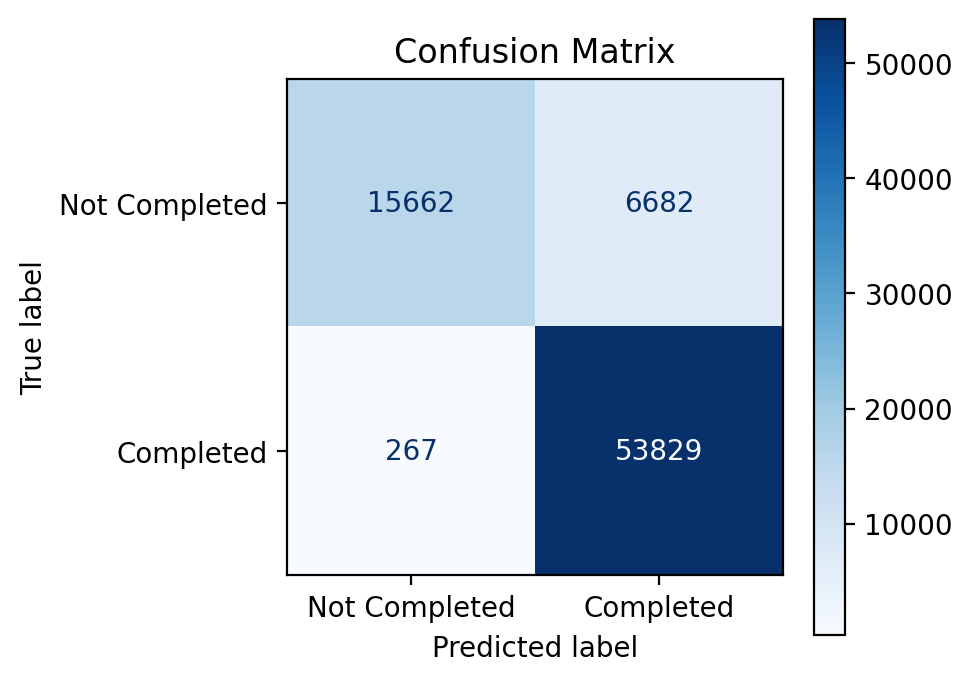

Accuracy score: 90.91%
Balanced accuracy score: 84.8%


In [21]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))

ConfusionMatrixDisplay.from_estimator(grid_01.best_estimator_,
                                      X_test, y_test,
                                      ax=ax,
                                      display_labels=['Not Completed', 'Completed'],
                                      cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

print(f'Accuracy score: {round(grid_01.score(X_test, y_test) * 100, 2)}%')
print(f'Balanced accuracy score: {round(balanced_accuracy_score(y_test, grid_01.best_estimator_.predict(X_test)) * 100, 2)}%')

##### Logistic Regression Coefficients

In [22]:
coefs = pd.DataFrame(zip(col_transformer.get_feature_names_out(),
                         grid_01.best_estimator_.coef_[0]),
                         columns = ["Feature", "Coef"])

display(coefs.sort_values("Coef", ascending = False).head(15))
display(coefs.sort_values("Coef", ascending = False).tail(15))

,Feature,Coef
135,CompletionDateType_ACTUAL,2.385820
292,LocationStatus_No_data,1.711084
325,CentralContactRole_No_data,1.225026
146,PrimaryCompletionDateType_ACTUAL,1.168753
137,CompletionDateType_No_data,1.091474
3,StudyFirstSubmitDate,0.498214
148,PrimaryCompletionDateType_No_data,0.388943
305,ReferenceType_DERIVED,0.382309
2,CompletionDate,0.328414
151,StartDateType_No_data,0.310194


,Feature,Coef
78,HealthyVolunteers_False,-0.114038
5,LastUpdateSubmitDate,-0.121589
82,SamplingMethod_No_data,-0.124956
59,DesignTimePerspective_PROSPECTIVE,-0.127278
123,LeadSponsorClass_FED,-0.135916
257,Phase_No_data,-0.161504
360,LocationCountry_No_data,-0.217455
92,OrgClass_NIH,-0.219640
1,PrimaryCompletionDate,-0.226498
304,ReferenceType_No_data,-0.321632


Some of these field values suggest the presence of information that has been added concomitant or after study completion. For example the presence of a CompletionDateType_ACTUAL vs. CompletionDateType_ESTIMATED is likely of limited true predictive interest. Nevertheless, the temporality of many of these fields is difficult to determine in reference to the time point of the submission of the data and the dates of the study itself.

Terminated studies also exhibit ACTUAL CompletionsDateTypes, as do some, but not all Withdrawn studies. Further research will be needed to completely separate the data into its correct predictive temporality.

##### Add Synthetic Minority Oversampling Technique (SMOTE)

In [23]:
smote_pipe = imb_Pipeline([('smote', SMOTE()),
                           ('regressor', LogisticRegression(max_iter=1000))])

params = {'regressor__C': [1]}

grid_02 = GridSearchCV(smote_pipe, param_grid=params, n_jobs=n_jobs)

start_time = time()
grid_02.fit(X_train, y_train)
print(f'GridSearch completed in {round(time() - start_time, 1)}s')

print(f'Train accuracy: {round(grid_02.score(X_train, y_train) * 100, 2)}%')
print(f'Test accuracy: {round(grid_02.score(X_test, y_test) * 100, 2)}%')
print(f'Best parameters: {grid_02.best_params_}')

GridSearch completed in 364.2s
Train accuracy: 89.59%
Test accuracy: 89.45%
Best parameters: {'regressor__C': 1}


The SMOTE model has a slightly more balanced output, but at the cost of reduced overall accuracy compared to the standard logistic regression model.

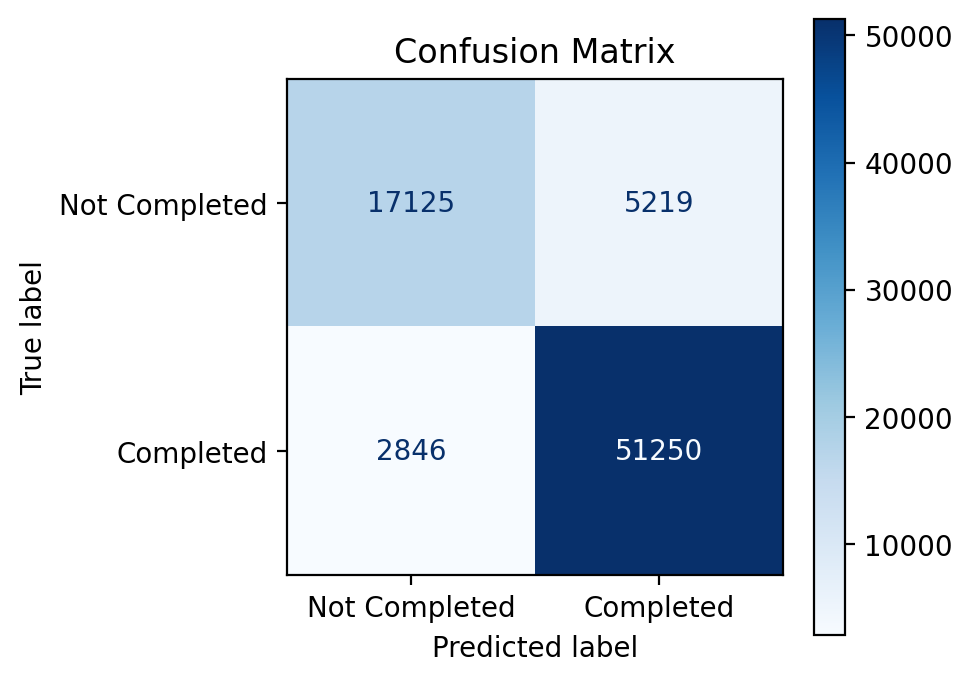

Accuracy score: 89.45%
Balanced accuracy score: 85.69%


In [24]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))

ConfusionMatrixDisplay.from_estimator(grid_02.best_estimator_,
                                      X_test, y_test,
                                      ax=ax,
                                      display_labels=['Not Completed', 'Completed'],
                                      cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

print(f'Accuracy score: {round(grid_02.score(X_test, y_test) * 100, 2)}%')
print(f'Balanced accuracy score: {round(balanced_accuracy_score(y_test, grid_02.best_estimator_.predict(X_test)) * 100, 2)}%')

#### Sequential Neural Network Model

The most basic Neural Network (NN) model should mimic the results of the logistic regression model.

In [25]:
X_train.shape

(305756, 554)

In [26]:
clear_session()

model_01 = Sequential([Input(shape=(X_train.shape[1],)),
                       Dense(X_train.shape[1], activation='relu'),
                       Dense(1, activation='sigmoid')])

model_01.compile(optimizer=Adam(learning_rate=0.0005), # Default learning_rate=0.001
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model_01.summary()

batch_size = int((X_train.shape[0] / 200)) + 1
print(f'Using batch size {batch_size} for {round(X_train.shape[0] / batch_size, 3)} total batches in dataset')

# Fit the model
start_time = time()
history = model_01.fit(X_train, y_train,
                       epochs=20,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       callbacks=[EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                restore_best_weights=True)])

print(f'\nTraining time {round((time() - start_time) / 60, 3)} min\n')

print('Generating test set predictions')
preds = model_01.predict(X_test)
pred_labels = preds >= 0.5

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 554)            │       307,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           555 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,025 (1.18 MB)

 Trainable params: 308,025 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Using batch size 1529 for 199.971 total batches in dataset
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8618 - loss: 0.3479 - val_accuracy: 0.9063 - val_loss: 0.2548
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9098 - loss: 0.2415 - val_accuracy: 0.9093 - val_loss: 0.2456
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9150 - loss: 0.2248 - val_accuracy: 0.9104 - val_loss: 0.2406
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9180 - loss: 0.2141 - val_accuracy: 0.9116 - val_loss: 0.2390
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9198 - loss: 0.2065 - val_accuracy: 0.9113 - val_loss: 0.2412
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9214 - loss: 0.2035 - val_accuracy: 0.9105 - val_loss: 0.2418
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9231 - loss: 0.1956 - val_accuracy: 0.9100 - val_loss: 0.2418
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 

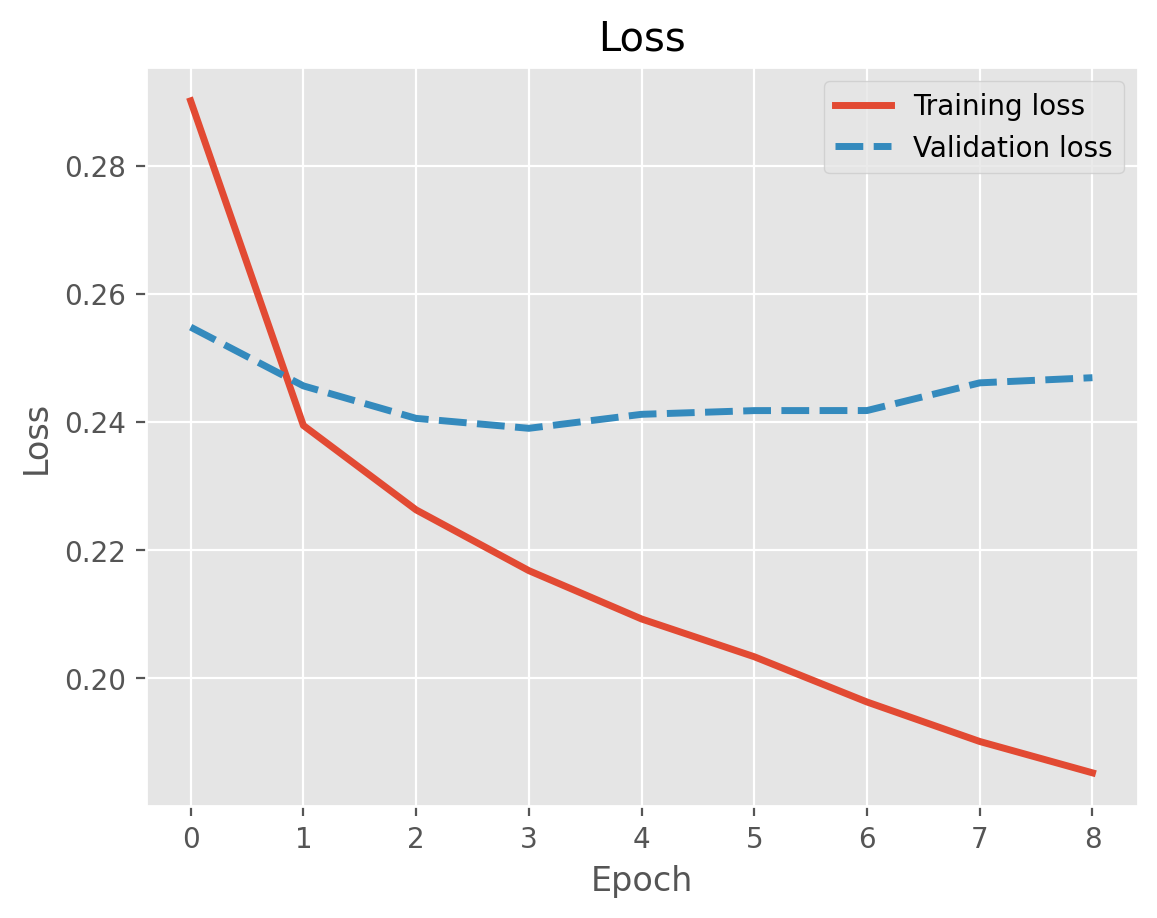

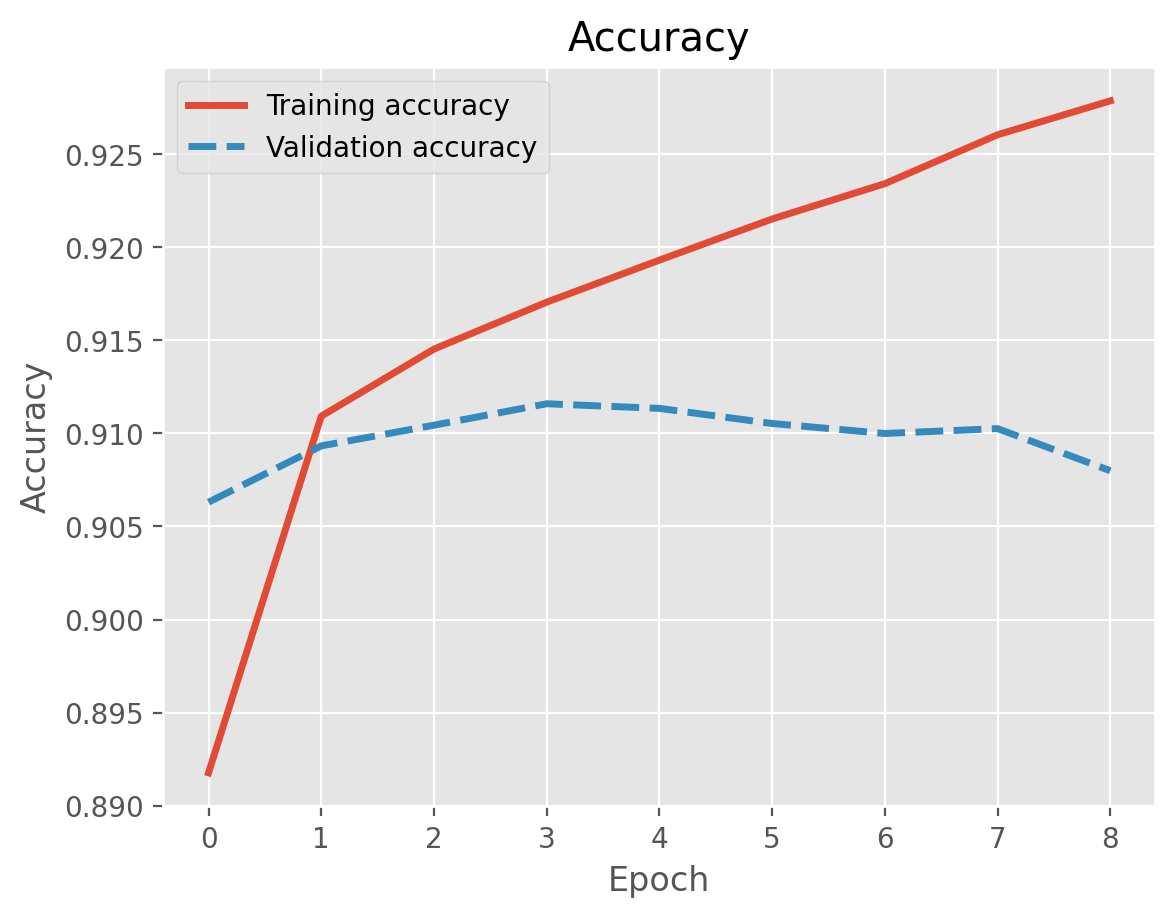

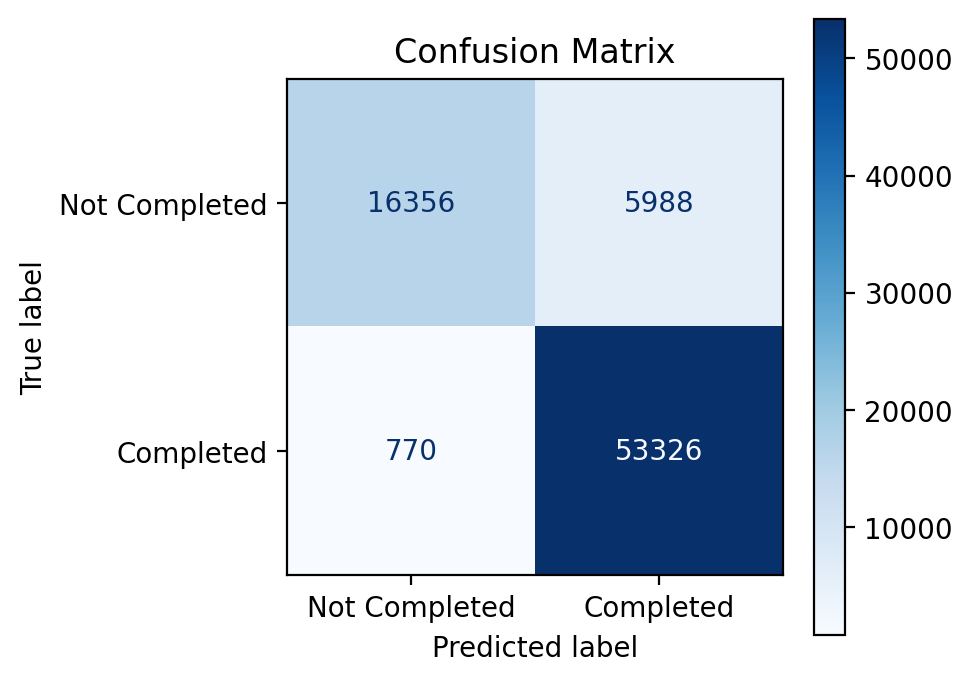

Best accuracy score: 91.16%
Balanced accuracy score: 85.89%


In [27]:
plt.style.use('ggplot')

for metric in ['loss', 'accuracy']:

    accuracy_hist = pd.DataFrame({'Training ' + metric: history.history[metric],
                                  'Validation ' + metric: history.history['val_' + metric]})

    sns.lineplot(accuracy_hist, linewidth=2.5)

    plt.title(metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.show();

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))

ConfusionMatrixDisplay.from_predictions(y_test, pred_labels,
                                      ax=ax,
                                      display_labels=['Not Completed', 'Completed'],
                                      cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

print(f'Best accuracy score: {round(max(history.history['val_accuracy']) * 100, 2)}%')
print(f'Balanced accuracy score: {round(balanced_accuracy_score(y_test, pred_labels) * 100, 2)}%')

A more complex NN model 

In [28]:
model_02 = Sequential([Input(shape=(X_train.shape[1],)),
                       Dense(X_train.shape[1], activation='relu'),
                       Dropout(0.5),
                       Dense(1024, activation='relu'),
                       Dropout(0.5),
                       Dense(256, activation='relu'),
                       Dropout(0.5),
                       Dense(32, activation='relu'),
                       Dense(1, activation='sigmoid')])

model_02.compile(optimizer=Adam(learning_rate=0.0005), # Default learning_rate=0.001
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model_02.summary()

batch_size = int((X_train.shape[0] / 200)) + 1
print(f'Using batch size {batch_size} for {round(X_train.shape[0] / batch_size, 3)} total batches in dataset')

# Fit the model
start_time = time()
history = model_02.fit(X_train, y_train,
                       epochs=20,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       callbacks=[EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                restore_best_weights=True)])

print(f'\nTraining time {round((time() - start_time) / 60, 3)} min\n')

print('Generating test set predictions')
preds = model_02.predict(X_test)
pred_labels = preds >= 0.5

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 554)            │       307,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 554)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       568,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,146,447 (4.37 MB)

 Trainable params: 1,146,447 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

Using batch size 1529 for 199.971 total batches in dataset
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8301 - loss: 0.4179 - val_accuracy: 0.9051 - val_loss: 0.2633
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9037 - loss: 0.2670 - val_accuracy: 0.9082 - val_loss: 0.2597
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9070 - loss: 0.2541 - val_accuracy: 0.9092 - val_loss: 0.2490
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9084 - loss: 0.2493 - val_accuracy: 0.9104 - val_loss: 0.2475
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9104 - loss: 0.2425 - val_accuracy: 0.9108 - val_loss: 0.2454
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2367 - val_accuracy: 0.9120 - val_loss: 0.2440
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9129 - loss: 0.2328 - val_accuracy: 0.9124 - val_loss: 0.2420
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━

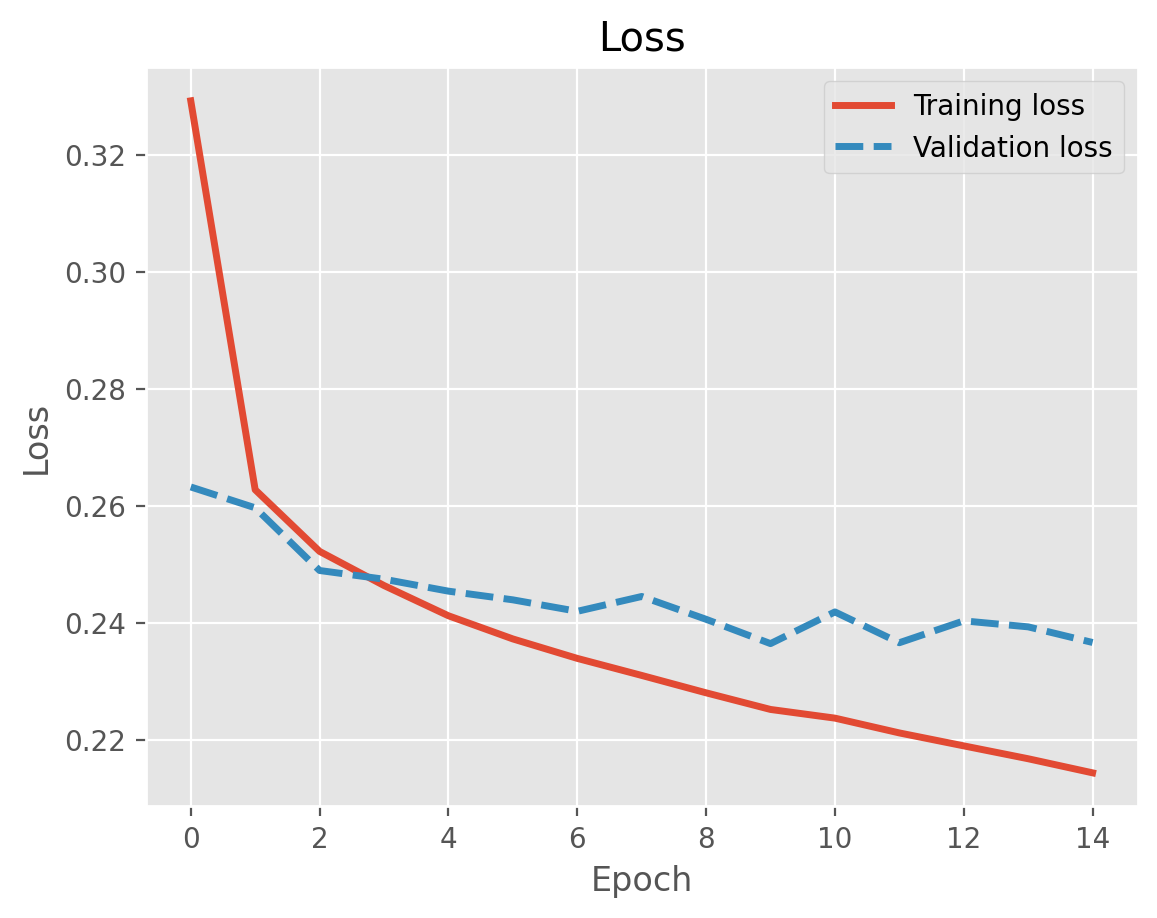

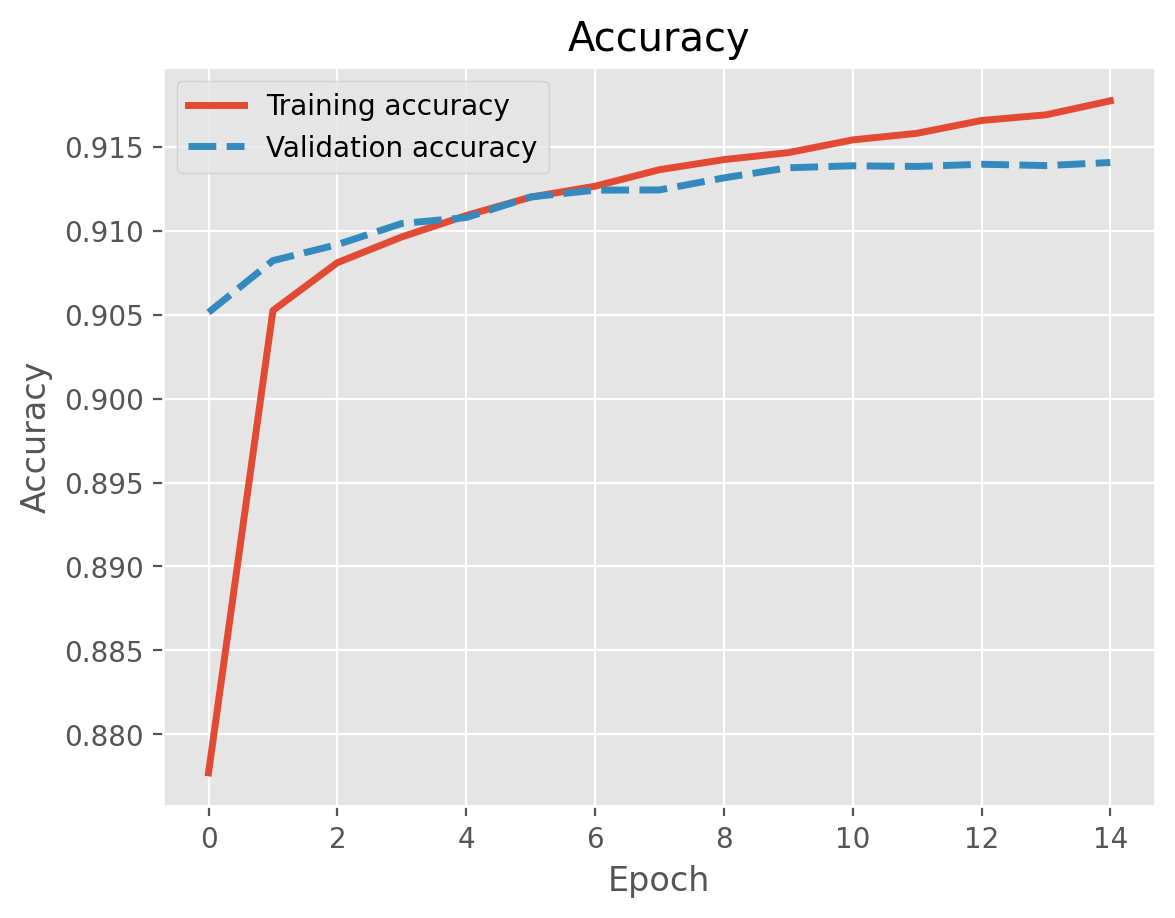

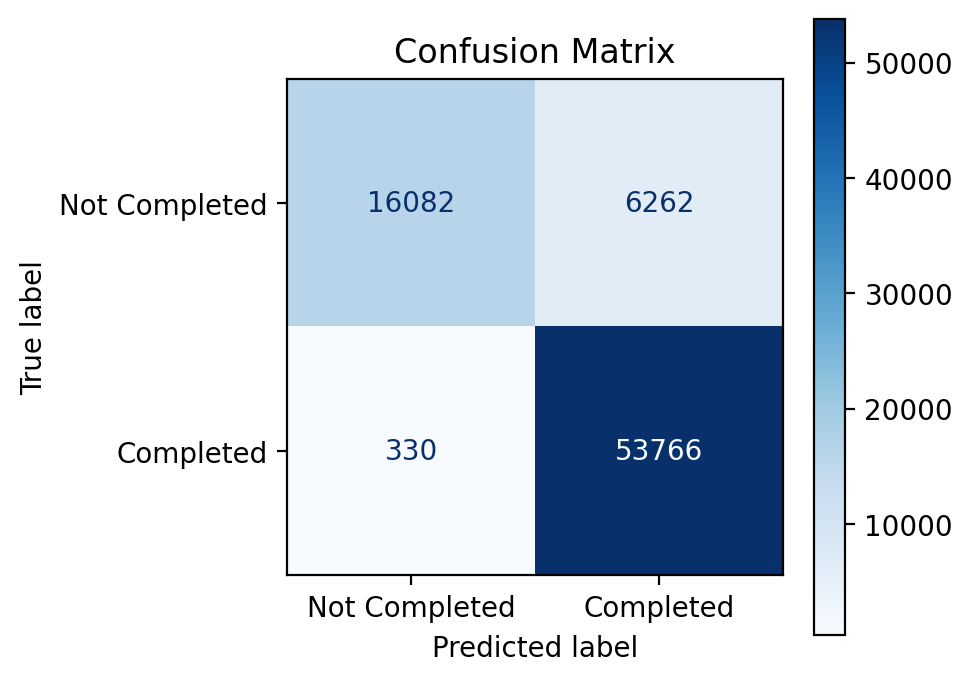

Best accuracy score: 		91.41%
Balanced accuracy score:	85.68%


In [30]:
plt.style.use('ggplot')

for metric in ['loss', 'accuracy']:

    accuracy_hist = pd.DataFrame({'Training ' + metric: history.history[metric],
                                  'Validation ' + metric: history.history['val_' + metric]})

    sns.lineplot(accuracy_hist, linewidth=2.5)

    plt.title(metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.show();

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))

ConfusionMatrixDisplay.from_predictions(y_test, pred_labels,
                                      ax=ax,
                                      display_labels=['Not Completed', 'Completed'],
                                      cmap='Blues')
plt.title('Confusion Matrix')
plt.show();

print(f'Best accuracy score: \t\t{round(max(history.history['val_accuracy']) * 100, 2)}%')
print(f'Balanced accuracy score:\t{round(balanced_accuracy_score(y_test, pred_labels) * 100, 2)}%')

## Conclusion

Analysis of 383,135 clinical study records revealed a wealth of information in ClinicalTrials.gov with utility to industry. The nature of the data made it difficult to determine which fields may represent information known before, during, or after a study has been conducted. Additional subject matter expertise in clinical trial data management would be beneficial for furthering these studies and enabling the true predictive power of these data.

### Model results

All models developed were able to successfully predict study completion better than baseline. Traditional logistic regression and Neural Network models performed similarly. The complex neural network approach was able to slightly outperform all other models. Both neural network models were able to outperformed the logistic progression models in terms of accuracy and balanced accuracy without the need for SMOTE. It's notable, that the compute time required to train the basic neural networks was lower than that of the logistic regression models, while achieving comparable, or slightly higher performance.

| Model | Accuracy Score | Balanced Accuracy Score | Train Time |
| - | :-: | :-: | :-: |
| *Baseline* | *70.7%* | | |
| Logistic Regression | 90.9% | 84.8% | 50s |
| Logistic Regression with SMOTE | 89.5% | 85.7% | 381s |
| Basic Neural Network | 91.2% | 86.0% | 21s |
| Complex Sequential Neural Network | 91.4% | 86.0% | 187s |

### Further Research
- Given additional resources, further analysis could help guide the design and implementation of clinical trials as well if provide a predictive model of ongoing study health and future study success.
- A full retrospective analysis of study design and reported results could identify specific approaches associated with clinical trial success.
- Snapshots of the comprehensive set of trial data at multiple time points during study planning and throughout implementation would improve predictive power and prevent data leakage.
- Integration of additional data sources connecting the development of health interventions across multiple studies and ultimate product marketability would be instrumental for continued research. 
- NLP analysis of free-text fields, particularly in regard to detail protocol design and trial results may yield additional benefits.